$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

# Regression between time series

In this notebook, we consider the problem of regression between time series. We have two time series $\{\bm{\xi}_t^{IN}\}_{t=0}^{N}$ and $\{\bm{\xi}_t^{OUT}\}_{t=0}^{N}$ that happen simultaneously and are dependent. The goal is to predict $\{\bm{\xi}_t^{OUT}\}_{t=0}^{N}$ given observation of full or partial sequence $IN$. 

In the context of Programming by Demonstration, and more precisely in assistive robotics, this could be applied to problems where the robot has to react or synchronize to a human user. The two time series refer to variable describing the human and the robot actuation. They are examples of the task to learn. During the execution of the task, the robot actuation needs to be adapted to the human which can be seen as a regression with, as input, the human time serie and, as output, the robot actuation.

We compare three different regression techniques:

***Gaussian Mixture Regression (GMR)***

The first is [Gaussian Mixture Regression (GMR)](http://mlg.eng.cam.ac.uk/zoubin/papers/nips93.pdf) and is based on computing conditional probability in a joint density encoded by a Gaussian Mixture Model (GMM). This technique does not consider any temporal dependency. 

***Hidden Markov Model (HMM)***

In the second, the joint density between the two time series is encoded as an [Hidden Markov Model (HMM)](http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf), which adds an temporal dependency. 

***Hidden Semi-Markov Model (HSMM)***

Finally, we use [Hidden Semi-Markov model (HSMM)](http://www.cs.ubc.ca/~murphyk/papers/segment.pdf) which allows for more precise encoding of the durations of states. 

For this notebook, we use dataset of handwriting letters. One letter is the input, another is the output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # loading data from matlab
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import pbdlib as pbd
import pbdlib.plot
from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

# Example 1 : Disambiguation

In this first example, we show the advantage of encoding temporal dependencies through Markovian model. It is useful to disambiguate situations by taking into account the past. 

In [2]:
nb_states = 5  # choose the number of states in HMM or clusters in GMM

### Loading dataset

In this example, letter **X** is used as input and **C** as output. The intersection of the **X** is an ambiguous position. In order to be able to localize in the writing process, history should be taken into account : we have to know which of the two strokes we were doing.

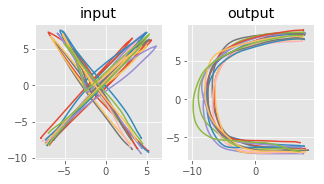

In [3]:
letter_in = 'X' # INPUT LETTER: choose a letter in the alphabet
letter_out = 'C' # OUTPUT LETTER: choose a letter in the alphabet

datapath = os.path.dirname(pbd.__file__) + '/data/2Dletters/'

data_in = loadmat(datapath + '%s.mat' % letter_in)
data_out = loadmat(datapath + '%s.mat' % letter_out)

demos_in = [d['pos'][0][0].T for d in data_in['demos'][0]] # cleaning matlab data
demos_out = [d['pos'][0][0].T for d in data_out['demos'][0]] # cleaning matlab data

demos = [np.concatenate([d_in, d_out], axis=1) 
         for d_in, d_out in zip(demos_in, demos_out)]

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(5., 2.5)

[ax[i].set_title(s) for i, s in enumerate(['input', 'output'])]

for p_in, p_out in zip(demos_in, demos_out):
    ax[0].plot(p_in[:, 0], p_in[:, 1])
    ax[1].plot(p_out[:, 0], p_out[:, 1])    

### Training  models

We train a GMM, HMM and HSMM over the concatenation of input and output time series. These models encode the joint probability of input-output. The states (or clusters) are Multivariate Normal Distributions (MVNs) with full covariance matrix. The mean and covariance can be decomposed and displayed the following way : 

$\bm{\mu}_i = \begin{bmatrix} \bm{\mu}_i^{IN} \\  \bm{\mu}_i^{OUT} \end{bmatrix},\quad 
\bm{\Sigma}_i = \begin{bmatrix} \bm{\Sigma}_i^{IN} & \bm{\Sigma}_i^{IN, OUT} \\
 \bm{\Sigma}_i^{OUT, IN} & \bm{\Sigma}_i^{OUT} \end{bmatrix}$

GMM did not converge before reaching max iteration. Consider augmenting the number of max iterations.


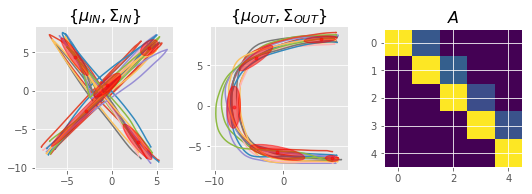

In [4]:
# creating models
gmm = pbd.GMM(nb_states=nb_states)
hmm = pbd.HMM(nb_states=nb_states)
hsmm = pbd.HSMM(nb_states=nb_states)

# initializing model by splitting the demonstrations in k bins
[model.init_hmm_kbins(demos) for model in [gmm, hmm, hsmm]] 

# EM to train model
gmm.em(np.concatenate(demos), reg=1e-8) 
hmm.em(demos, reg=1e-8) 
hsmm.em(demos, reg=1e-8) 

# plotting demos
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(7.5, 2.8)

for p_in, p_out in zip(demos_in, demos_out):
    ax[0].plot(p_in[:, 0], p_in[:, 1])
    ax[1].plot(p_out[:, 0], p_out[:, 1])    

[ax[i].set_title(s, fontsize=16) 
     for i, s in enumerate([r'$\{\mu_{IN}, \Sigma_{IN}\}$',
                            '$\{\mu_{OUT}, \Sigma_{OUT}\}$', r'$A$'])]

plt.tight_layout()
# use dim for selecting dimensions of GMM to plot
pbd.plot_gmm(gmm.mu, gmm.sigma, ax=ax[0], dim=[0, 1]); 
pbd.plot_gmm(gmm.mu, gmm.sigma, ax=ax[1], dim=[2, 3]); 

# plotting transition matrix
ax[2].imshow(np.log(hmm.Trans+1e-10), interpolation='nearest', 
             vmin=-5, cmap='viridis');
plt.tight_layout()

### Computing states activations
As a first step for regression, we compute the activation of each state (or cluster), given the input sequence. 

***GMM***

For GMM, the activation of state $i$ at time step $t$ is defined as :
\begin{align*}
h_{t,i} = \frac{\pi_i \;
	\mathcal{N}(\bm{\xi}_t^{IN}|\,\bm{\mu}_i^{IN},\bm{\Sigma}_i^{IN})}{\sum_{k=1}^{K}\pi_k \;
	\mathcal{N}(\bm{\xi}_t^{IN}|\,\bm{\mu}_k^{IN},\bm{\Sigma}_k^{IN})}
\end{align*}

***HMM-HSMM***

For HMM and HSMM the activations are based on [forward messages](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm) $\alpha_{t,i}$.

\begin{equation}
  h_{t,i} = \frac{\alpha_{t,i}}{\sum_{k=1}^K \alpha_{t,k}} ,
  \quad\mathrm{with}\quad
  \alpha_{t,i} = \Big(\sum\limits_{j=1}^K \alpha_{t-1,j}\; A_{j,i}\Big) \;
	\mathcal{N}\big(\bm{\xi}^{IN}_t |\;\bm{\mu}^{IN}_i,\bm{\Sigma}^{IN}_i\big) ,
\end{equation}

where $A$ is the HMM transition matrix. These activations takes into account the temporal dependencies.





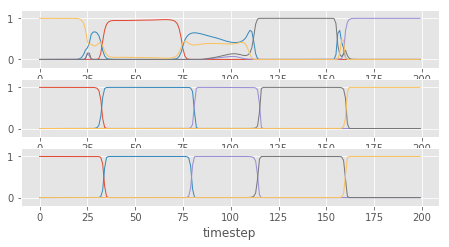

In [5]:
n = 0

resp_gmm = gmm.compute_resp(demos_in[n], marginal=slice(0, 2))

alpha_hmm, _, _, _, _ = hmm.compute_messages(
    demos_in[n], marginal=slice(0, 2))

alpha_hsmm, _, _, _, _ = hsmm.compute_messages(
    demos_in[n], marginal=slice(0, 2))


fig, ax = plt.subplots(nrows=3)
fig.set_size_inches(7.5,3.6)

ax[0].plot(resp_gmm.T , lw=1);
ax[1].plot(alpha_hmm.T, lw=1);
ax[2].plot(alpha_hsmm.T, lw=1);

[ax[i].set_ylim([-0.2, 1.2]) for i in range(3)]
plt.xlabel('timestep');

With the GMM, there is an ambiguity in the activation at the intersection of the **X**. Multiple states are activate and we cannot distinguish from which one to regenerate the output letter **C**. Adding temporal dependencies through Markov models removes these ambiguities by modeling the sequencing of the states.

### Reconstruction
If we now regenerate the output letters from these activation, the GMM gives a poor reconstruction, that jumps from parts to parts of the output letter. In this example, the advantages of the HSMM is not clear but this will be explained in the next. 

In [6]:
mu_est_gmm, sigma_est_gmm = gmm.condition(
    demos_in[1], dim_in=slice(0, 2), dim_out=slice(2, 4))
mu_est_hmm, sigma_est_hmm = hmm.condition(
    demos_in[1], dim_in=slice(0, 2), dim_out=slice(2, 4))
mu_est_hsmm, sigma_est_hsmm = hsmm.condition(
    demos_in[1], dim_in=slice(0, 2), dim_out=slice(2, 4))

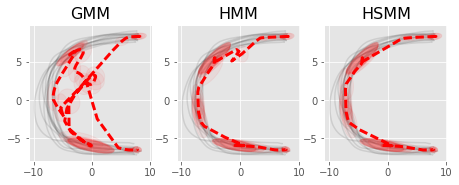

In [7]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(7.5, 2.5)

for p_in, p_out in zip(demos_in, demos_out):
    ax[0].plot(p_out[:, 0], p_out[:, 1],'k', alpha=0.1)
    ax[1].plot(p_out[:, 0], p_out[:, 1],'k', alpha=0.1)
    ax[2].plot(p_out[:, 0], p_out[:, 1],'k', alpha=0.1)

[ax[i].set_title(s, fontsize=16) 
     for i, s in enumerate(['GMM', 'HMM', 'HSMM'])]
    
ax[0].plot(mu_est_gmm[:, 0], mu_est_gmm[:,1 ], 'r--', lw=3)
ax[1].plot(mu_est_hmm[:, 0], mu_est_hmm[:,1 ], 'r--', lw=3)
ax[2].plot(mu_est_hsmm[:, 0], mu_est_hsmm[:,1 ], 'r--', lw=3)

pbd.plot_gmm(
    mu_est_gmm[::5], sigma_est_gmm[::5], ax=ax[0], swap=True, alpha=0.05)
pbd.plot_gmm(
    mu_est_hmm[::5], sigma_est_hmm[::5], ax=ax[1], swap=True, alpha=0.05)
pbd.plot_gmm(
    mu_est_hsmm[::5], sigma_est_hsmm[::5], ax=ax[2], swap=True, alpha=0.05)

# Example 2
In the first example, there was a strong dependence between the two time series in the sense that the sequence of state and its timing can be precisely determined by the input sequence. For illustrating this, imagine making an high-five to a robot. The robot does not need to precisely know the timing of the gesture as it can rely on you to give it and just synchronize.  

However, in some cases, the timing should be more precisely known by the robot. For example, if the robot should follow a complex procedure with precise timing while you don't move. In the HMM, the timing is not explicitly encoded. It is done only implicitly through the transition matrix and the self transition probability $A_{i,i}$. In HSMM, this self transition is set to $0$ and the duration is encoded as a countdown timer whose duration follow a distribution of time, allowing a more precise retrieval of the temporal characteristics of a task.

### Dataset
For this example, the input is just Gaussian noise, which does not gives any information on the output.

In [8]:
letter_out = 'C' # choose a letter in the alphabet

data_out = loadmat(datapath + '%s.mat' % letter_out)

demos_out = [d['pos'][0][0].T for d in data_out['demos'][0]] 
demos_in = [np.random.multivariate_normal(np.zeros(2), np.eye(2), d.shape[0]) 
            for d in demos_out] 

demos = [np.concatenate([d_in, d_out], axis=1) 
         for d_in, d_out in zip(demos_in, demos_out)]

Converged after 51 iterations: -7.266e+00


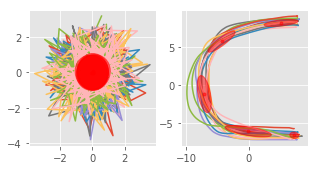

In [9]:
gmm = pbd.GMM(nb_states=nb_states)
hmm = pbd.HMM(nb_states=nb_states)
hsmm = pbd.HSMM(nb_states=nb_states)

# initializing model
[model.init_hmm_kbins(demos) for model in [gmm, hmm, hsmm]] 

# EM to train model
gmm.em(np.concatenate(demos), reg=1e-3) 
hmm.em(demos, reg=1e-3) 
hsmm.em(demos, reg=1e-3) 

# plotting demos
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(5., 2.5)

for p_in, p_out in zip(demos_in, demos_out):
    ax[0].plot(p_in[:, 0], p_in[:, 1])
    ax[1].plot(p_out[:, 0], p_out[:, 1])    
    
# use dim for selecting dimensions of GMM to plot
pbd.plot_gmm(gmm.mu, gmm.sigma, ax=ax[0], dim=[0, 1]);
pbd.plot_gmm(gmm.mu, gmm.sigma, ax=ax[1], dim=[2, 3]); 

#### Compute messages with marginal probabilities

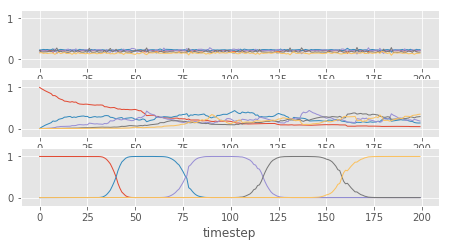

In [10]:
n = 0

resp_gmm = gmm.compute_resp(demos_in[n], marginal=slice(0, 2))
alpha_hsmm, _, _, _, _ = hsmm.compute_messages(
    demos_in[n], marginal=slice(0, 2))
alpha_hmm, _, _, _, _ = hmm.compute_messages(
    demos_in[n], marginal=slice(0, 2))


fig, ax = plt.subplots(nrows=3)
fig.set_size_inches(7.5,3.6)

ax[0].plot(resp_gmm.T , lw=1);
ax[1].plot(alpha_hmm.T, lw=1);
ax[2].plot(alpha_hsmm.T, lw=1);

[ax[i].set_ylim([-0.2, 1.2]) for i in range(3)]
plt.xlabel('timestep');

In [11]:
mu_est_gmm, sigma_est_gmm = gmm.condition(
    demos_in[1], dim_in=slice(0, 2), dim_out=slice(2, 4))
mu_est_hmm, sigma_est_hmm = hmm.condition(
    demos_in[1], dim_in=slice(0, 2), dim_out=slice(2, 4))
mu_est_hsmm, sigma_est_hsmm = hsmm.condition(
    demos_in[1], dim_in=slice(0, 2), dim_out=slice(2, 4))

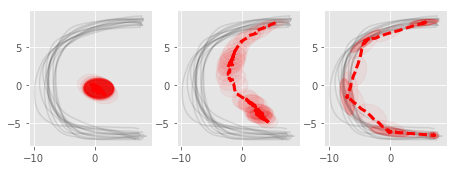

In [12]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(7.5, 2.5)

for p_in, p_out in zip(demos_in, demos_out):
    ax[0].plot(p_out[:, 0], p_out[:, 1],'k', alpha=0.1)
    ax[1].plot(p_out[:, 0], p_out[:, 1],'k', alpha=0.1)
    ax[2].plot(p_out[:, 0], p_out[:, 1],'k', alpha=0.1)
    

ax[0].plot(mu_est_gmm[:, 0], mu_est_gmm[:,1 ], 'r--', lw=3)
ax[1].plot(mu_est_hmm[:, 0], mu_est_hmm[:,1 ], 'r--', lw=3)
ax[2].plot(mu_est_hsmm[:, 0], mu_est_hsmm[:,1 ], 'r--', lw=3)

pbd.plot_gmm(
    mu_est_gmm[::5], sigma_est_gmm[::5], ax=ax[0], swap=True, alpha=0.05)
pbd.plot_gmm(
    mu_est_hmm[::5], sigma_est_hmm[::5], ax=ax[1], swap=True, alpha=0.05)
pbd.plot_gmm(
    mu_est_hsmm[::5], sigma_est_hsmm[::5], ax=ax[2], swap=True, alpha=0.05)